1. Wykorzystując seaborn narysuj histogram reprezentujący rozkład głębokości terminala naftowego dla trzech wybranych typów portu.

['River (Natural)', 'Open Roadstead', 'Coastal (Natural)', 'Coastal (Breakwater)', 'Canal or Lake', 'River (Basins)', 'River (Tide Gates)', 'Coastal (Tide Gates)', 'Typhoon Harbor', ' ']
Categories (10, object): [' ', 'Canal or Lake', 'Coastal (Breakwater)', 'Coastal (Natural)', ..., 'River (Basins)', 'River (Natural)', 'River (Tide Gates)', 'Typhoon Harbor']


<Axes: xlabel='Oil Terminal Depth (m)', ylabel='Count'>

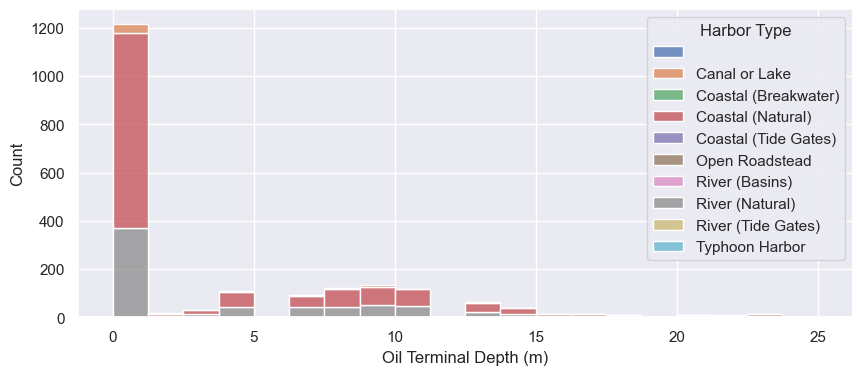

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
ports_df = pd.read_csv("Dataset_WorldPortIndex.csv", index_col=0)
ports_df["Harbor Type"] = ports_df["Harbor Type"].astype('category')
print(ports_df["Harbor Type"].unique())
ports_selected_df = ports_df[ports_df['Harbor Type'].isin(["River (Natural)", "Canal or Lake", "Coastal (Natural)"])]
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.histplot(data=ports_selected_df, x="Oil Terminal Depth (m)", hue="Harbor Type", multiple="stack", bins = 20, binrange=(0, 25), ax=ax)

2. Wykorzystując stałe ze SciPy utwórz nową Tablicę na podstawie wczytanych danych AnnualSurfaceTemperatureChange gdzie jednostką są stopnie Fahrenheita a nie Celcjusza.

In [2]:
from scipy.constants import convert_temperature
temp_df = pd.read_csv("Dataset_AnnualSurfaceTemperatureChange.csv", index_col=0)
melt_temp_df = temp_df.melt(
    id_vars=["Country", "ISO3", "Unit"], 
    value_vars=["F" + str(n) for n in range(1961, 2023)], 
    var_name="year", 
    value_name="temp_changes (°C)") 

melt_temp_df["year"] = melt_temp_df["year"].map(lambda x: np.datetime64(x.strip("F"))) 

if "temp_changes (°C)" in melt_temp_df.columns:
    melt_temp_df['temp_changes (°F)'] = convert_temperature(
    melt_temp_df['temp_changes (°C)'], 
        'Celsius', 
        'Fahrenheit'
    )
melt_temp_df.head()

Country ISO3            Unit       year  \
0  Afghanistan, Islamic Rep. of  AFG  Degree Celsius 1961-01-01   
1                       Albania  ALB  Degree Celsius 1961-01-01   
2                       Algeria  DZA  Degree Celsius 1961-01-01   
3                American Samoa  ASM  Degree Celsius 1961-01-01   
4      Andorra, Principality of  AND  Degree Celsius 1961-01-01   

   temp_changes (°C)  temp_changes (°F)  
0             -0.113            31.7966  
1              0.627            33.1286  
2              0.164            32.2952  
3              0.079            32.1422  
4              0.736            33.3248

3. Wybierz jakąś zależność, którą chcesz sprawdzić między wybranymi kolumnami zbioru danych WorldPortIndex. Wykonaj podział na zbiór treningowy i testowy w stosunku 80:20, wytrenuj klasyfikator i sprawdź jego skuteczność.

In [3]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

data = ports_df.loc[
    (ports_df["World Water Body"] != ' ') &
    (~ports_df["Entrance Restriction - Ice"].isin(["Unknown"])) &
    (ports_df["Latitude"] >= -90) & (ports_df["Latitude"] <= 90) & 
    (ports_df["Longitude"] >= -180) & (ports_df["Longitude"] <= 180), 
    ["World Water Body", "Latitude", "Longitude", "Entrance Restriction - Ice"]
] 
data["Entrance Restriction - Ice"] = data["Entrance Restriction - Ice"].map({'No':0, 'Yes':1}) 
data["World Water Body"] = data["World Water Body"].astype('category') 
print(data["World Water Body"].unique())
data["World Water Body"] = data["World Water Body"].cat.codes
print(data["World Water Body"].unique())

X = data[["Latitude", "Longitude", "Entrance Restriction - Ice"]]
y = data["World Water Body"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

clf = DecisionTreeClassifier().fit(X_train, y_train) 
clf.score(X_test, y_test)

['North Atlantic Ocean', 'Teluk Bone; Banda Sea; South Pacific Ocean', 'Indian Ocean', 'Bismarck Sea; South Pacific Ocean', 'South Pacific Ocean', ..., 'Red Sea; Indian Ocean', 'Torres Strait; South Pacific Ocean', 'Strait of Hormuz; Indian Ocean', 'Gulf of Carpentaria; Arafura Sea; South Pacif..., 'Timor Sea; Indian Ocean']
Length: 126
Categories (126, object): ['Adriatic Sea; Mediterranean Sea; North Atlant..., 'Aegean Sea; Mediterranean Sea; North Atlantic..., 'Alaska-Canada coastal waters; North Pacific O..., 'Amundsen Gulf; Northwest Passages; Arctic Ocean', ..., 'Tyrrhenian Sea; Mediterranean Sea; North Atla..., 'Viscount Melville Sound; Northwest Passages; ..., 'White Sea; Barents Sea; Arctic Ocean', 'Yellow Sea; North Pacific Ocean']
[ 87 118  63  22 108  88  64  75 110 105  76  91  54  77  58  46  12 100
  89  27  79   1  84   2 101  20  23  16  26  52 106  48 103  99  29  24
  39  61 107  33  74  86 122  65   9 104  69 125 116  13  47  93   0  81
  17  40  28  66  94 117   5 

0.8666666666666667

In [4]:
plt.figure(figsize=(16,8))
plot_tree(clf, filled=True)
plt.title("Decision tree predicting port type")
plt.show()

4. ★ Używając geopandas zwizualizuj mapę europejskich portów ze zbioru danych WorldPortIndex.

In [11]:
import geopandas as gpd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

european_ports = ports_df.loc[(ports_df["Latitude"] >= 35) & (ports_df["Latitude"] <= 71) & (ports_df["Longitude"] >= -25) & (ports_df["Longitude"] <= 45)]
gdf = gpd.GeoDataFrame(european_ports, geometry=gpd.points_from_xy(european_ports.Longitude, european_ports.Latitude))
#ax = world.clip([-30, 30, 50, 80]).plot(color="white", edgecolor="black")
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
world.boundary.plot(ax=ax, linewidth=1, color='black')
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.6)
plt.title('Geographical Distribution of European Ports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


5. Dopasuj regresję liniową do wyliczonej średniej zmiany temperatury z zadania 7. z ostatnich zajęć.
Zwizualizuj prostą uzyskaną z modelu wraz z przedziałem wewnątrz kwartyli temperatur wykorzystując wykres typu fill_between.

coefficients:  [0.02617008]
intercept:  -51.60438177643042
Root Mean Squared Error (RMSE): 0.17
Coefficient of determination: 0.88


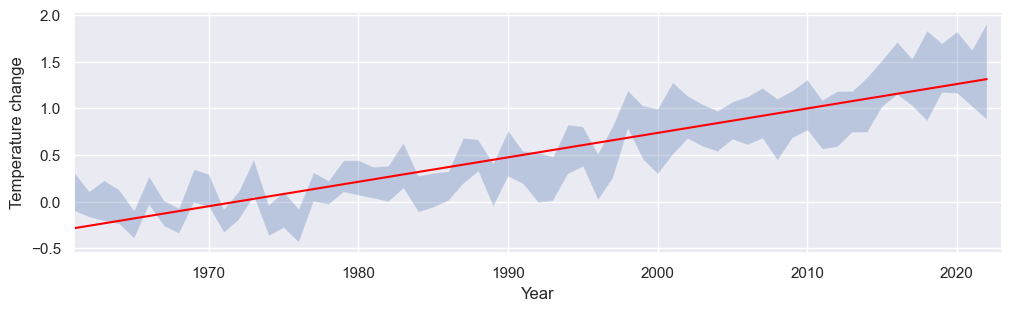

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
temp_df = pd.read_csv("Dataset_AnnualSurfaceTemperatureChange.csv", index_col=0)
melt_temp_df = temp_df.melt(
    id_vars=["Country", "ISO3", "Unit"], 
    value_vars=["F" + str(n) for n in range(1961, 2023)],    
    var_name="year", 
    value_name="temp_changes") 

melt_temp_df["year"] = melt_temp_df["year"].map(lambda x: int(x.strip("F")))
filtered_data = melt_temp_df.loc[melt_temp_df["temp_changes"].notnull(), ["Country", "ISO3", "Unit","year","temp_changes"]]
average_temp = filtered_data.groupby("year")["temp_changes"].mean().reset_index()
#average_temp.plot(kind="line")

model = LinearRegression()
X = average_temp[['year']].values.reshape(-1, 1)
y = average_temp['temp_changes'].values
 
model.fit(X,y, sample_weight=None)
y_pred = model.predict(X)
print('coefficients: ', model.coef_)
print('intercept: ', model.intercept_)
print('Root Mean Squared Error (RMSE): %.2f'% np.sqrt(mean_squared_error(y, y_pred))) #średni błąd przewidywania wartości przez model
print('Coefficient of determination: %.2f'% r2_score(y, y_pred)) # stopień zmienności danych wyjaśniany przez zmienną niezależną, przyjmuje wartość 0-1

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
quartiles = filtered_data.groupby("year")["temp_changes"].quantile([0.25, 0.75]).unstack()
ax.fill_between(average_temp["year"], quartiles[0.25], quartiles[0.75], alpha= .3)
ax.plot(average_temp["year"], y_pred, c="red")
ax.set_xlim(1961, 2023)
ax.grid(True, axis='y')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature change')
plt.show()
